In [25]:
import pandas as pd
import numpy as np
import sys, importlib
import pymc3 as pm
import os
import arviz as az
import utils.utils as utils_fucns
from plotly.subplots import make_subplots
import plotly.graph_objs as go

importlib.reload(sys.modules["utils.utils"])

<module 'utils.utils' from '/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/GithubRepo/utils/utils.py'>

# Preprocessing Data

In [26]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2021-01-01'
VALID_START_DATE = '2021-01-01'
VALID_END_DATE = '2022-01-01'
TEST_START_DATE = '2022-01-01'
TEST_END_DATE = '2023-01-01'

In [27]:
stock_index_name = "NASDAQ100"

In [28]:
df = pd.read_csv(f"./Data/Prices_Indicators/Prices_indicators_{stock_index_name}.csv", index_col="Unnamed: 0")
df = df.sort_values(['date','tic'], ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback = data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.iloc[-126:].cov().values
  cov_list.append(covs)

  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [29]:
train_df = utils_fucns.data_split(df, TRAIN_START_DATE,TRAIN_END_DATE)
valid_df = utils_fucns.data_split(df, VALID_START_DATE,VALID_END_DATE)
test_df = utils_fucns.data_split(df, TEST_START_DATE,TEST_END_DATE)

print(len(train_df))
print(len(valid_df))
print(len(test_df))

218751
19908
19829


In [30]:
train_df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2010-01-04,4.840000,4.940000,4.660000,4.496876,9837300,AAL,0,0.264201,4.990098,3.970660,56.734689,56.164068,11.645737,4.087727,3.736084,"[[0.0030208484386229583, 0.0001437290962925755...",tic AAL AAPL ADBE ...
0,2010-01-04,7.622500,7.660714,7.585000,6.487534,493729600,AAPL,0,0.119025,6.551487,5.578209,62.133194,168.774731,33.760635,6.069350,6.016179,"[[0.0030208484386229583, 0.0001437290962925755...",tic AAL AAPL ADBE ...
0,2010-01-04,36.650002,37.299999,36.650002,37.090000,4710200,ADBE,0,0.362072,38.064119,35.385880,55.961154,61.331407,15.511034,36.478000,35.719167,"[[0.0030208484386229583, 0.0001437290962925755...",tic AAL AAPL ADBE ...
0,2010-01-04,31.790001,32.189999,31.610001,22.851315,2102700,ADI,0,0.513462,23.075292,21.587582,63.868739,124.367292,48.437846,21.921864,20.715286,"[[0.0030208484386229583, 0.0001437290962925755...",tic AAL AAPL ADBE ...
0,2010-01-04,38.226513,38.226513,37.489025,27.178541,3930120,ADP,0,0.069858,27.650382,26.871561,55.521056,-36.385884,7.630433,27.342997,26.681627,"[[0.0030208484386229583, 0.0001437290962925755...",tic AAL AAPL ADBE ...


In [31]:
train_df.tic.unique().shape[0]

79

# Human Preferences

In [32]:
# feedback_df = utils_fucns.create_comparison_dataset(train_df, 1)
# pref_portfolios = utils_fucns.get_preferred_portfolio(feedback_df)

# GroundTruth Model

## GT Model = 0.6 mean + 0.4 (-variance) (200 observations)

In [33]:
def GT_pref_model(criteria):
    return 0.6*criteria[0] - 0.4*criteria[1]

In [34]:
num_comparisons = 200
model_name = f"GT_model_1_{num_comparisons}"
GT_pref_model_data_path = f"./Data/GT_pref_models/{stock_index_name}/{model_name}_data.json"
GT_pref_model_scaler_path = f"./Params/GT_pref_models/{stock_index_name}/{model_name}/scaler.joblib"

In [36]:
feedback_df = utils_fucns.create_comparison_dataset(train_df, num_comparisons)
feedback_sc_df = utils_fucns.scale_feedback_df(feedback_df, GT_pref_model_scaler_path)
pref_portfolios = utils_fucns.get_preferred_portfolio(feedback_sc_df, GT_pref_model)
utils_fucns.rebalance_classes(feedback_sc_df, 2)
feedback_sc_df.reset_index().to_json(GT_pref_model_data_path)

In [37]:
feedback_sc_df = pd.read_json(GT_pref_model_data_path)
feedback_sc_df.drop('index', inplace=True, axis=1)
feedback_sc_df.head()

,mean1,var1,mean2,var2,port_returns1,port_returns2,pareto_fr,pareto_fr_w,pref_portfolio
0,0.179346,0.090631,0.064149,0.038191,"[0.0182298073, -0.006495359500000001, -0.00854...","[0.0064967805, -0.0029123645, -0.0079427592, -...","[[0.000271504, 0.0016195544], [0.0005084083, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.41...",0
1,0.242371,0.206246,0.075115,0.010588,"[-0.0073155498000000005, -0.000957567200000000...","[-0.0187056487, 0.0074573046, 0.018126158, 0.0...","[[5.7967700000000004e-05, 0.0010546614], [6.10...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04...",0
2,0.261521,0.073751,0.290748,0.086846,"[0.0198717102, 0.0081310756, 0.0030151009, -0....","[0.0238177923, 0.0079624973, 0.0046149254, -0....","[[0.00033408040000000003, 0.0028201641], [0.00...","[[0.0, 0.0024744125000000002, 0.0, 0.0, 0.0, 0...",1
3,0.154699,0.008267,0.153153,0.008101,"[0.0016194792000000001, -0.0012442477, -0.0060...","[0.0016197614, -0.0012154975, -0.0061124849, 0...","[[8.6111e-05, 0.0025184155], [8.03405e-05, 0.0...","[[0.0, 0.0, 0.0016706947000000002, 0.0, 0.0, 0...",0
4,0.457316,0.206508,0.159074,0.016623,"[-0.0276135772, 0.0295370397, -0.00082176, -0....","[-0.0077325869, 0.0037438534000000002, 0.00472...","[[6.47062e-05, 0.0012415718], [0.0005126040000...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0


In [38]:
with pm.Model() as preference_model:
    beta = pm.Dirichlet("beta", a=np.ones(2)/2)
    sigma = pm.Exponential("sigma", 1)
    
    vm = beta[0]*feedback_sc_df.mean2.values + beta[1]*-feedback_sc_df.var2.values
    vr = beta[0]*feedback_sc_df.mean1.values + beta[1]*-feedback_sc_df.var1.values

    Norm_dist = pm.Normal.dist(0, 1)
    p = 1 - pm.math.exp(Norm_dist.logcdf(-(vm - vr)/pm.math.sqrt(2*sigma**2)))

    Y_obs = pm.Bernoulli("Y_obs", p=p, observed=feedback_sc_df.pref_portfolio.values)

In [39]:
with preference_model:
    trace = pm.sample(1000, tune = 10000, return_inferencedata=False, target_accept=0.999)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

Sampling 4 chains for 10_000 tune and 1_000 draw iterations (40_000 + 4_000 draws total) took 113 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
T

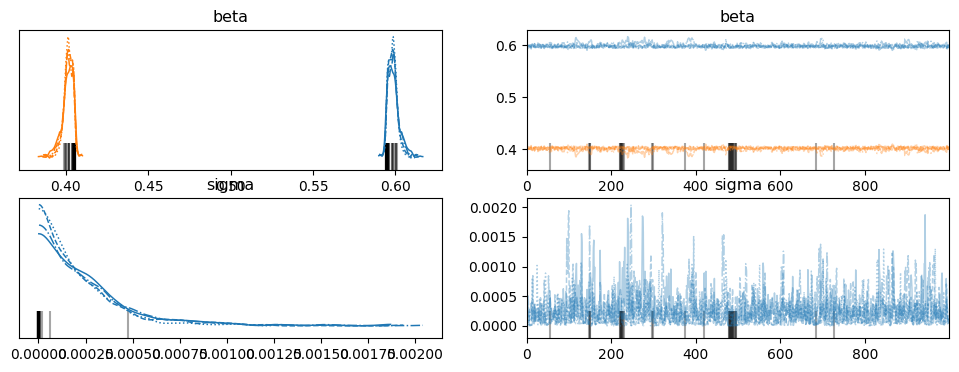

In [40]:
with preference_model:
    az.plot_trace(trace)

In [41]:
with preference_model:
    display(az.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.599,0.003,0.594,0.605,0.0,0.0,537.0,530.0,1.01
beta[1],0.401,0.003,0.395,0.406,0.0,0.0,537.0,530.0,1.01
sigma,0.000,0.000,0.000,0.001,0.0,0.0,630.0,632.0,1.01


In [42]:
idx = feedback_sc_df.pareto_fr.sample(1).index[0]
eff_front_df = pd.DataFrame(np.array(feedback_sc_df.pareto_fr.iloc[idx])[:, [1, 0]], columns=['mean', 'var'])
eff_front_df["weights"] = feedback_sc_df.pareto_fr_w.iloc[idx]

GT_eff_port = utils_fucns.get_eff_port(eff_front_df, GT_pref_model_scaler_path, GT_pref_model, trace["beta"], plot_eff_front=True)

## GT Model = 0.6 mean + 0.4 (-variance) (500 observations)

In [43]:
def GT_pref_model(criteria):
    return 0.6*criteria[0] - 0.4*criteria[1]

In [44]:
num_comparisons = 500
model_name = f"GT_model_1_{num_comparisons}"
GT_pref_model_data_path = f"./Data/GT_pref_models/{stock_index_name}/{model_name}_data.json"
GT_pref_model_scaler_path = f"./Params/GT_pref_models/{stock_index_name}/{model_name}/scaler.joblib"

In [45]:
feedback_df = utils_fucns.create_comparison_dataset(train_df, num_comparisons)
feedback_sc_df = utils_fucns.scale_feedback_df(feedback_df, GT_pref_model_scaler_path)
pref_portfolios = utils_fucns.get_preferred_portfolio(feedback_sc_df, GT_pref_model)
utils_fucns.rebalance_classes(feedback_sc_df, 2)
feedback_sc_df.reset_index().to_json(GT_pref_model_data_path)

In [46]:
feedback_sc_df = pd.read_json(GT_pref_model_data_path)
feedback_sc_df.drop('index', inplace=True, axis=1)
feedback_sc_df.head()

,mean1,var1,mean2,var2,port_returns1,port_returns2,pareto_fr,pareto_fr_w,pref_portfolio
0,0.339018,0.229226,0.337425,0.225800,"[0.0047450459000000006, 0.006469073200000001, ...","[0.0048988886, 0.005700261000000001, -0.026112...","[[5.1947800000000004e-05, 0.001422925300000000...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.77...",1
1,0.374690,0.182891,0.288097,0.078000,"[0.017161025400000002, -0.0258270684, -0.00568...","[0.0024504709, -0.0145475655, -0.0080523451, 0...","[[0.0002895923, 0.0033305429], [5.95893e-05, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.50...",0
2,0.185699,0.021942,0.232206,0.089317,"[0.009722659600000001, -0.0102085668, 0.009398...","[-0.0057936127, -0.0240072386, 0.0095341110000...","[[6.14885e-05, 0.0019502419], [7.9942300000000...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
3,0.080547,0.003941,0.305379,0.096988,"[0.0021599018, 0.0043971463, 0.001305723500000...","[-0.0030569691, 0.0094673315, -0.0014813995, -...","[[3.48256e-05, 0.0014300568000000001], [0.0001...","[[0.0, 0.0968997097, 0.0, 0.0, 0.0420682917, 0...",1
4,0.737272,0.424920,0.760101,0.493001,"[0.0047556691, 0.0369473401, 0.0131081817, 0.0...","[0.0006339551, 0.0380775004, 0.006308935500000...","[[4.2386300000000004e-05, 0.001599409400000000...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.90...",0


In [47]:
with pm.Model() as preference_model:
    beta = pm.Dirichlet("beta", a=np.ones(2)/2)
    sigma = pm.Exponential("sigma", 1)
    
    vm = beta[0]*feedback_sc_df.mean2.values + beta[1]*-feedback_sc_df.var2.values
    vr = beta[0]*feedback_sc_df.mean1.values + beta[1]*-feedback_sc_df.var1.values

    Norm_dist = pm.Normal.dist(0, 1)
    p = 1 - pm.math.exp(Norm_dist.logcdf(-(vm - vr)/pm.math.sqrt(2*sigma**2)))

    Y_obs = pm.Bernoulli("Y_obs", p=p, observed=feedback_sc_df.pref_portfolio.values)

In [48]:
with preference_model:
    trace = pm.sample(1000, tune = 10000, return_inferencedata=False, target_accept=0.999)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

Sampling 4 chains for 10_000 tune and 1_000 draw iterations (40_000 + 4_000 draws total) took 135 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Th

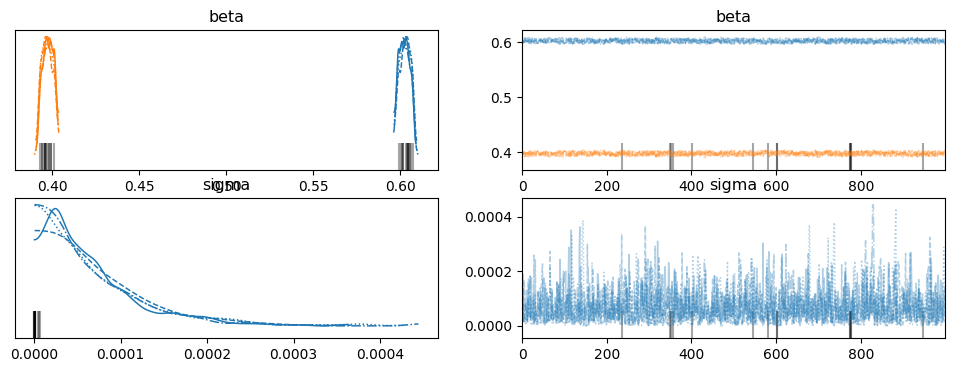

In [49]:
with preference_model:
    az.plot_trace(trace)

In [50]:
with preference_model:
    display(az.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.603,0.003,0.597,0.608,0.0,0.0,958.0,1661.0,1.01
beta[1],0.397,0.003,0.392,0.403,0.0,0.0,958.0,1661.0,1.01
sigma,0.000,0.000,0.000,0.000,0.0,0.0,1234.0,956.0,1.00


In [51]:
idx = feedback_sc_df.pareto_fr.sample(1).index[0]
eff_front_df = pd.DataFrame(np.array(feedback_sc_df.pareto_fr.iloc[idx])[:, [1, 0]], columns=['mean', 'var'])
eff_front_df["weights"] = feedback_sc_df.pareto_fr_w.iloc[idx]

GT_eff_port = utils_fucns.get_eff_port(eff_front_df, GT_pref_model_scaler_path, GT_pref_model, trace["beta"], plot_eff_front=True)

## GT Model = 0.4 mean + 0.6 (-variance) (200 observations)

In [52]:
def GT_pref_model(criteria):
    return 0.4*criteria[0] - 0.6*criteria[1]

In [53]:
num_comparisons = 200
model_name = f"GT_model_2_{num_comparisons}"
GT_pref_model_data_path = f"./Data/GT_pref_models/{stock_index_name}/{model_name}_data.json"
GT_pref_model_scaler_path = f"./Params/GT_pref_models/{stock_index_name}/{model_name}/scaler.joblib"

In [54]:
feedback_df = utils_fucns.create_comparison_dataset(train_df, num_comparisons)
feedback_sc_df = utils_fucns.scale_feedback_df(feedback_df, GT_pref_model_scaler_path)
pref_portfolios = utils_fucns.get_preferred_portfolio(feedback_sc_df, GT_pref_model)
utils_fucns.rebalance_classes(feedback_sc_df, 2)
feedback_sc_df.reset_index().to_json(GT_pref_model_data_path)

In [55]:
feedback_sc_df = pd.read_json(GT_pref_model_data_path)
feedback_sc_df.drop('index', inplace=True, axis=1)
feedback_sc_df.head()

,mean1,var1,mean2,var2,port_returns1,port_returns2,pareto_fr,pareto_fr_w,pref_portfolio
0,0.487588,0.124227,0.503318,0.141706,"[0.0269605604, 0.0006019297, -0.0121069416, -0...","[0.0253120265, 0.002242337, -0.0144903284, -0....","[[0.0001995694, 0.0035736104], [0.0012295002, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,0.756763,0.720096,0.358675,0.081644,"[-0.0312774059, -0.0057463862, 0.0094785491, 0...","[-0.0054182023, 0.0030799505000000003, 0.01502...","[[7.244430000000001e-05, 0.0016507113000000001...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75...",1
2,0.299317,0.052094,0.420128,0.151781,"[0.0383558197, -0.0013146063, 0.0044389866, 0....","[0.038254228200000004, -0.0008673698, 0.001433...","[[0.00011391460000000001, 0.0024350116], [0.00...","[[0.054254197500000004, 0.10321165780000001, 0...",0
3,0.323937,0.055738,0.330464,0.061743,"[0.0036447654, -0.0018387495000000002, 0.00275...","[0.0039702604, -0.002489232, 0.0032330212, 0.0...","[[6.11985e-05, 0.0018201892000000001], [9.6308...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
4,0.515424,0.204077,0.120310,0.009858,"[0.0136469781, 0.0091703717, 0.0069104271, -0....","[0.0090302147, 0.0088409186, 0.006353246900000...","[[8.65478e-05, 0.0020433249], [0.0021562729, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23...",0


In [56]:
with pm.Model() as preference_model:
    beta = pm.Dirichlet("beta", a=np.ones(2)/2)
    sigma = pm.Exponential("sigma", 1)
    
    vm = beta[0]*feedback_sc_df.mean2.values + beta[1]*-feedback_sc_df.var2.values
    vr = beta[0]*feedback_sc_df.mean1.values + beta[1]*-feedback_sc_df.var1.values

    Norm_dist = pm.Normal.dist(0, 1)
    p = 1 - pm.math.exp(Norm_dist.logcdf(-(vm - vr)/pm.math.sqrt(2*sigma**2)))

    Y_obs = pm.Bernoulli("Y_obs", p=p, observed=feedback_sc_df.pref_portfolio.values)

In [57]:
with preference_model:
    trace = pm.sample(1000, tune = 10000, return_inferencedata=False, target_accept=0.999)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

Sampling 4 chains for 10_000 tune and 1_000 draw iterations (40_000 + 4_000 draws total) took 113 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
Th

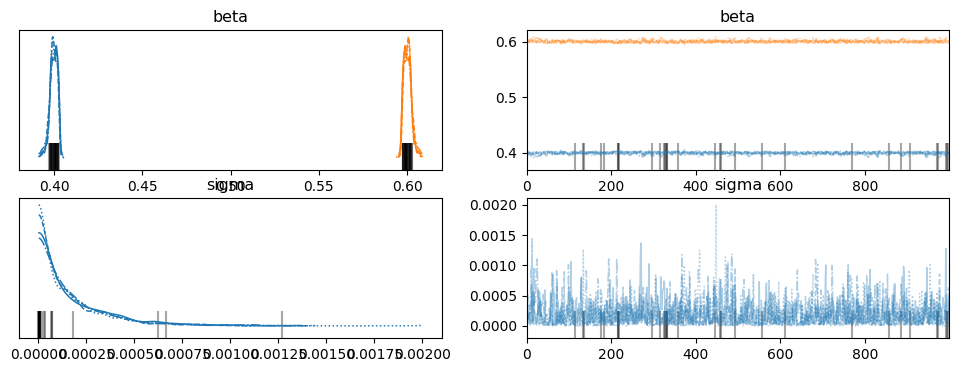

In [58]:
with preference_model:
    az.plot_trace(trace)

In [59]:
with preference_model:
    display(az.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.4,0.002,0.396,0.403,0.0,0.0,868.0,564.0,1.01
beta[1],0.6,0.002,0.597,0.604,0.0,0.0,868.0,564.0,1.01
sigma,0.0,0.000,0.000,0.001,0.0,0.0,842.0,819.0,1.00


In [60]:
idx = feedback_sc_df.pareto_fr.sample(1).index[0]
eff_front_df = pd.DataFrame(np.array(feedback_sc_df.pareto_fr.iloc[idx])[:, [1, 0]], columns=['mean', 'var'])
eff_front_df["weights"] = feedback_sc_df.pareto_fr_w.iloc[idx]

GT_eff_port = utils_fucns.get_eff_port(eff_front_df, GT_pref_model_scaler_path, GT_pref_model, trace["beta"], plot_eff_front=True)

## GT Model = 0.4 mean + 0.6 (-variance) (500 observations)

In [61]:
def GT_pref_model(criteria):
    return 0.4*criteria[0] - 0.6*criteria[1]

In [62]:
num_comparisons = 500
model_name = f"GT_model_2_{num_comparisons}"
GT_pref_model_data_path = f"./Data/GT_pref_models/{stock_index_name}/{model_name}_data.json"
GT_pref_model_scaler_path = f"./Params/GT_pref_models/{stock_index_name}/{model_name}/scaler.joblib"

In [63]:
feedback_df = utils_fucns.create_comparison_dataset(train_df, num_comparisons)
feedback_sc_df = utils_fucns.scale_feedback_df(feedback_df, GT_pref_model_scaler_path)
pref_portfolios = utils_fucns.get_preferred_portfolio(feedback_sc_df, GT_pref_model)
utils_fucns.rebalance_classes(feedback_sc_df, 2)
feedback_sc_df.reset_index().to_json(GT_pref_model_data_path)

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/GithubRepo/utils/utils.py:35: RuntimeWarning:

invalid value encountered in true_divide



In [64]:
feedback_sc_df = pd.read_json(GT_pref_model_data_path)
feedback_sc_df.drop('index', inplace=True, axis=1)
feedback_sc_df.head()

,mean1,var1,mean2,var2,port_returns1,port_returns2,pareto_fr,pareto_fr_w,pref_portfolio
0,0.128237,0.034933,0.250084,0.110840,"[0.0013362966, -0.0163280169, 0.0033969691, -0...","[-0.005490753100000001, -0.0083959557, 0.00328...","[[8.05253e-05, 0.0013678901000000001], [8.9448...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08...",1
1,0.416798,0.110360,0.170349,0.012686,"[-0.0045186038, 0.0205620088, 0.011878394, 0.0...","[-0.0114049942, 0.0123644358, 0.0021812229, 0....","[[0.0013451327, 0.0049238574], [4.65264e-05, 0...","[[0.5130520193, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,0.317569,0.035181,0.527526,0.130877,"[0.0179484956, 0.0132112826, 0.0008590679, -0....","[0.032906268, 0.0138958708, -0.0130924062, 0.0...","[[4.64908e-05, 0.0019341236], [4.06261e-05, 0....","[[0.0340867407, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,0.462604,0.149591,0.530842,0.206768,"[0.0373847994, 0.0088053396, -0.015827032, -0....","[0.0368413339, 0.0141417178, -0.0139574478, -0...","[[0.0008554875, 0.0056139729], [0.0003717749, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0016384...",0
4,0.364702,0.121257,0.415455,0.175751,"[0.020388094500000002, -0.0198050058, 0.017455...","[0.0276086922, -0.0304710254, 0.0228941072, 0....","[[0.0001530938, 0.0026538417], [6.22262e-05, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0


In [65]:
with pm.Model() as preference_model:
    beta = pm.Dirichlet("beta", a=np.ones(2)/2)
    sigma = pm.Exponential("sigma", 1)
    
    vm = beta[0]*feedback_sc_df.mean2.values + beta[1]*-feedback_sc_df.var2.values
    vr = beta[0]*feedback_sc_df.mean1.values + beta[1]*-feedback_sc_df.var1.values

    Norm_dist = pm.Normal.dist(0, 1)
    p = 1 - pm.math.exp(Norm_dist.logcdf(-(vm - vr)/pm.math.sqrt(2*sigma**2)))

    Y_obs = pm.Bernoulli("Y_obs", p=p, observed=feedback_sc_df.pref_portfolio.values)

In [66]:
with preference_model:
    trace = pm.sample(1000, tune = 10000, return_inferencedata=False, target_accept=0.999)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

Sampling 4 chains for 10_000 tune and 1_000 draw iterations (40_000 + 4_000 draws total) took 113 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Ther

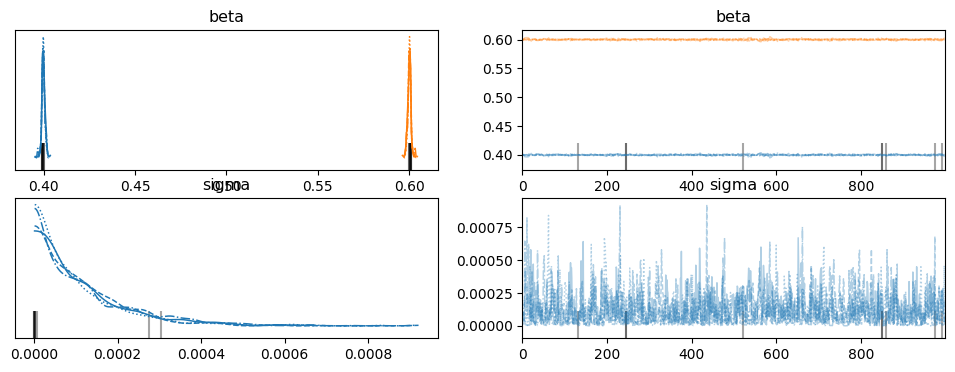

In [67]:
with preference_model:
    az.plot_trace(trace)

In [68]:
with preference_model:
    display(az.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.4,0.001,0.398,0.402,0.0,0.0,763.0,762.0,1.01
beta[1],0.6,0.001,0.598,0.602,0.0,0.0,763.0,762.0,1.01
sigma,0.0,0.000,0.000,0.000,0.0,0.0,744.0,920.0,1.00


In [69]:
idx = feedback_sc_df.pareto_fr.sample(1).index[0]
eff_front_df = pd.DataFrame(np.array(feedback_sc_df.pareto_fr.iloc[idx])[:, [1, 0]], columns=['mean', 'var'])
eff_front_df["weights"] = feedback_sc_df.pareto_fr_w.iloc[idx]

GT_eff_port = utils_fucns.get_eff_port(eff_front_df, GT_pref_model_scaler_path, GT_pref_model, trace["beta"], plot_eff_front=True)

## GT Model = 0.1 mean + 0.9 (-variance) (200 observations)

In [70]:
def GT_pref_model(criteria):
    return 0.1*criteria[0] - 0.9*criteria[1]

In [71]:
num_comparisons = 200
model_name = f"GT_model_3_{num_comparisons}"
GT_pref_model_data_path = f"./Data/GT_pref_models/{stock_index_name}/{model_name}_data.json"
GT_pref_model_scaler_path = f"./Params/GT_pref_models/{stock_index_name}/{model_name}/scaler.joblib"

In [72]:
feedback_df = utils_fucns.create_comparison_dataset(train_df, num_comparisons)
feedback_sc_df = utils_fucns.scale_feedback_df(feedback_df, GT_pref_model_scaler_path)
pref_portfolios = utils_fucns.get_preferred_portfolio(feedback_sc_df, GT_pref_model)
utils_fucns.rebalance_classes(feedback_sc_df, 2)
feedback_sc_df.reset_index().to_json(GT_pref_model_data_path)

In [73]:
feedback_sc_df = pd.read_json(GT_pref_model_data_path)
feedback_sc_df.drop('index', inplace=True, axis=1)
feedback_sc_df.head()

,mean1,var1,mean2,var2,port_returns1,port_returns2,pareto_fr,pareto_fr_w,pref_portfolio
0,0.288957,0.062334,0.356873,0.190522,"[0.0008113541000000001, -0.022727353500000002,...","[0.015503554000000001, -0.044068069200000004, ...","[[0.0001163023, 0.0021538062], [8.48239e-05, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,0.277841,0.029664,0.481966,0.259347,"[0.014453604200000001, 0.0029686247000000002, ...","[0.0168093549, -0.0060200918, -0.0117683568000...","[[5.9300200000000005e-05, 0.0021445591], [3.62...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2960269658, ...",0
2,0.456410,0.253083,0.477659,0.319560,"[-0.0125409204, -0.0040976331, 0.0146315441000...","[-0.0168332328, -0.0054217809, 0.0149041088000...","[[0.0010359365, 0.0045878949], [0.0004515353, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
3,0.257281,0.035627,0.076740,0.002917,"[0.009556494700000001, -7.93606e-05, 0.0154302...","[0.0053630811, -0.0068774023, 0.0100506693, -0...","[[3.62625e-05, 0.0012265879], [3.96842e-05, 0....","[[0.0, 0.2358807223, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,0.211912,0.105030,0.143019,0.039498,"[-0.0067517191, -0.0012705571, -0.0010739014, ...","[-0.0011843934, -0.0023139747, 0.0017535343, -...","[[0.0011650011, 0.0033928131], [0.001141606800...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.27...",1


In [74]:
with pm.Model() as preference_model:
    beta = pm.Dirichlet("beta", a=np.ones(2)/2)
    sigma = pm.Exponential("sigma", 1)
    
    vm = beta[0]*feedback_sc_df.mean2.values + beta[1]*-feedback_sc_df.var2.values
    vr = beta[0]*feedback_sc_df.mean1.values + beta[1]*-feedback_sc_df.var1.values

    Norm_dist = pm.Normal.dist(0, 1)
    p = 1 - pm.math.exp(Norm_dist.logcdf(-(vm - vr)/pm.math.sqrt(2*sigma**2)))

    Y_obs = pm.Bernoulli("Y_obs", p=p, observed=feedback_sc_df.pref_portfolio.values)

In [75]:
with preference_model:
    trace = pm.sample(1000, tune = 10000, return_inferencedata=False, target_accept=0.999)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

Sampling 4 chains for 10_000 tune and 1_000 draw iterations (40_000 + 4_000 draws total) took 94 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The

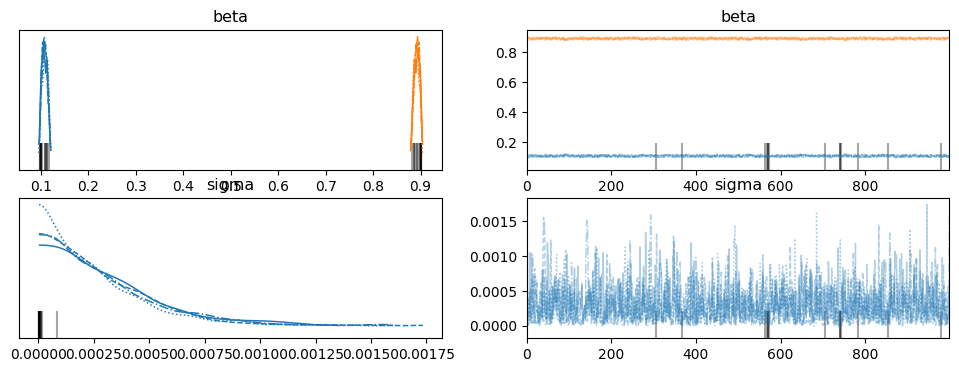

In [76]:
with preference_model:
    az.plot_trace(trace)

In [77]:
with preference_model:
    display(az.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.108,0.006,0.098,0.118,0.0,0.0,916.0,1912.0,1.01
beta[1],0.892,0.006,0.882,0.902,0.0,0.0,916.0,1912.0,1.01
sigma,0.000,0.000,0.000,0.001,0.0,0.0,1231.0,1026.0,1.00


In [78]:
idx = feedback_sc_df.pareto_fr.sample(1).index[0]
eff_front_df = pd.DataFrame(np.array(feedback_sc_df.pareto_fr.iloc[idx])[:, [1, 0]], columns=['mean', 'var'])
eff_front_df["weights"] = feedback_sc_df.pareto_fr_w.iloc[idx]

GT_eff_port = utils_fucns.get_eff_port(eff_front_df, GT_pref_model_scaler_path, GT_pref_model, trace["beta"], plot_eff_front=True)

## GT Model = 0.1 mean + 0.9 (-variance) (500 observations)

In [79]:
def GT_pref_model(criteria):
    return 0.1*criteria[0] - 0.9*criteria[1]

In [80]:
num_comparisons = 500
model_name = f"GT_model_3_{num_comparisons}"
GT_pref_model_data_path = f"./Data/GT_pref_models/{stock_index_name}/{model_name}_data.json"
GT_pref_model_scaler_path = f"./Params/GT_pref_models/{stock_index_name}/{model_name}/scaler.joblib"

In [81]:
feedback_df = utils_fucns.create_comparison_dataset(train_df, num_comparisons)
feedback_sc_df = utils_fucns.scale_feedback_df(feedback_df, GT_pref_model_scaler_path)
pref_portfolios = utils_fucns.get_preferred_portfolio(feedback_sc_df, GT_pref_model)
utils_fucns.rebalance_classes(feedback_sc_df, 2)
feedback_sc_df.reset_index().to_json(GT_pref_model_data_path)

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/GithubRepo/utils/utils.py:35: RuntimeWarning:

invalid value encountered in true_divide



In [82]:
feedback_sc_df = pd.read_json(GT_pref_model_data_path)
feedback_sc_df.drop('index', inplace=True, axis=1)
feedback_sc_df.head()

,mean1,var1,mean2,var2,port_returns1,port_returns2,pareto_fr,pareto_fr_w,pref_portfolio
0,0.086685,0.007948,0.302153,0.152179,"[-0.0007278487, 0.010696936, -6.95902e-05, -0....","[0.00044823510000000004, 0.0209673316, 0.01664...","[[5.12912e-05, 0.0014393277], [0.0002007879, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0016140198, 0.0, ...",0
1,0.190476,0.057052,0.044413,0.008992,"[0.0025227709, -0.013123331700000001, -0.01988...","[-0.0001880956, -0.0101432215, -0.0164193456, ...","[[5.60282e-05, 0.0011866048], [8.02231e-05, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15...",1
2,0.353544,0.136390,0.256921,0.055027,"[0.013422982600000001, 0.0144266273, -0.041760...","[0.0111651522, 0.0085033416, -0.0222495348, -0...","[[6.48102e-05, 0.0014311806], [8.61641e-05, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
3,0.334199,0.098811,0.216594,0.022115,"[0.0093741747, -0.0148861427, 0.0216338057, 0....","[0.0068240424, -0.0142851242, 0.01564781030000...","[[6.59996e-05, 0.0021374231], [5.53241e-05, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
4,0.456081,0.319393,0.202852,0.040652,"[-0.006035149300000001, 0.008975716600000001, ...","[-0.0072869431, 0.0030549600000000002, 0.00632...","[[0.0005130684, 0.0042426415], [5.87767e-05, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1


In [83]:
with pm.Model() as preference_model:
    beta = pm.Dirichlet("beta", a=np.ones(2)/2)
    sigma = pm.Exponential("sigma", 1)
    
    vm = beta[0]*feedback_sc_df.mean2.values + beta[1]*-feedback_sc_df.var2.values
    vr = beta[0]*feedback_sc_df.mean1.values + beta[1]*-feedback_sc_df.var1.values

    Norm_dist = pm.Normal.dist(0, 1)
    p = 1 - pm.math.exp(Norm_dist.logcdf(-(vm - vr)/pm.math.sqrt(2*sigma**2)))

    Y_obs = pm.Bernoulli("Y_obs", p=p, observed=feedback_sc_df.pref_portfolio.values)

In [84]:
with preference_model:
    trace = pm.sample(1000, tune = 10000, return_inferencedata=False, target_accept=0.999)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

Sampling 4 chains for 10_000 tune and 1_000 draw iterations (40_000 + 4_000 draws total) took 93 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There

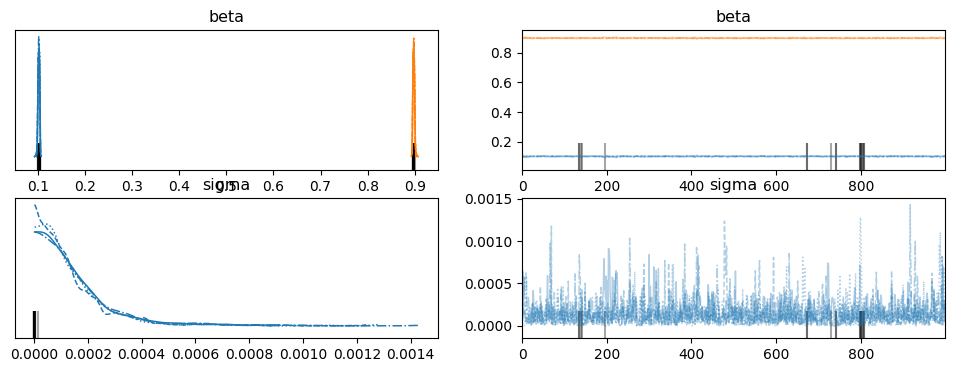

In [85]:
with preference_model:
    az.plot_trace(trace)

In [86]:
with preference_model:
    display(az.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.102,0.002,0.099,0.105,0.0,0.0,988.0,559.0,1.00
beta[1],0.898,0.002,0.895,0.901,0.0,0.0,988.0,559.0,1.00
sigma,0.000,0.000,0.000,0.000,0.0,0.0,829.0,659.0,1.01


In [87]:
idx = feedback_sc_df.pareto_fr.sample(1).index[0]
eff_front_df = pd.DataFrame(np.array(feedback_sc_df.pareto_fr.iloc[idx])[:, [1, 0]], columns=['mean', 'var'])
eff_front_df["weights"] = feedback_sc_df.pareto_fr_w.iloc[idx]

GT_eff_port = utils_fucns.get_eff_port(eff_front_df, GT_pref_model_scaler_path, GT_pref_model, trace["beta"], plot_eff_front=True)

## GT Model = 0.9 mean + 0.1 (-variance) (200 observations)

In [88]:
def GT_pref_model(criteria):
    return 0.9*criteria[0] - 0.1*criteria[1]

In [89]:
num_comparisons = 200
model_name = f"GT_model_4_{num_comparisons}"
GT_pref_model_data_path = f"./Data/GT_pref_models/{stock_index_name}/{model_name}_data.json"
GT_pref_model_scaler_path = f"./Params/GT_pref_models/{stock_index_name}/{model_name}/scaler.joblib"

In [90]:
feedback_df = utils_fucns.create_comparison_dataset(train_df, num_comparisons)
feedback_sc_df = utils_fucns.scale_feedback_df(feedback_df, GT_pref_model_scaler_path)
pref_portfolios = utils_fucns.get_preferred_portfolio(feedback_sc_df, GT_pref_model)
utils_fucns.rebalance_classes(feedback_sc_df, 2)
feedback_sc_df.reset_index().to_json(GT_pref_model_data_path)

In [91]:
feedback_sc_df = pd.read_json(GT_pref_model_data_path)
feedback_sc_df.drop('index', inplace=True, axis=1)
feedback_sc_df.head()

,mean1,var1,mean2,var2,port_returns1,port_returns2,pareto_fr,pareto_fr_w,pref_portfolio
0,0.197780,0.017185,0.096340,0.008075,"[0.0375068841, 0.0110859413, -0.00983458770000...","[0.0286673705, 0.0118535108, -0.0090192627, 0....","[[9.74181e-05, 0.0020169099], [0.0001153092, 0...","[[0.0056080463, 0.1069230828, 0.0, 0.0, 0.0, 0...",0
1,0.221026,0.036746,0.226797,0.042201,"[-0.0199620641, -0.0078409841, -0.0026350449, ...","[-0.0232645658, -0.0079877255, -0.002800955900...","[[7.76729e-05, 0.0018240459000000001], [4.7003...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07...",1
2,0.124548,0.009671,0.133562,0.011337,"[0.0060098481, -0.0013937611000000001, 0.00172...","[0.0055246221, -0.0024425151, 0.0026765736, 0....","[[5.64122e-05, 0.0013367665], [5.7683400000000...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
3,0.569165,0.221724,0.553378,0.181540,"[-0.0041547904, 0.0026864116000000003, 0.03268...","[-0.0066046640000000005, 0.003476957, 0.030996...","[[7.21952e-05, 0.0026320439], [0.0020533742000...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
4,0.120371,0.016660,0.054807,0.003448,"[0.0148595772, 0.005034469000000001, -0.009456...","[0.0046021172, 0.0027969543, -0.00131417440000...","[[6.867740000000001e-05, 0.0016140458], [5.047...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12...",0


In [92]:
with pm.Model() as preference_model:
    beta = pm.Dirichlet("beta", a=np.ones(2)/2)
    sigma = pm.Exponential("sigma", 1)
    
    vm = beta[0]*feedback_sc_df.mean2.values + beta[1]*-feedback_sc_df.var2.values
    vr = beta[0]*feedback_sc_df.mean1.values + beta[1]*-feedback_sc_df.var1.values

    Norm_dist = pm.Normal.dist(0, 1)
    p = 1 - pm.math.exp(Norm_dist.logcdf(-(vm - vr)/pm.math.sqrt(2*sigma**2)))

    Y_obs = pm.Bernoulli("Y_obs", p=p, observed=feedback_sc_df.pref_portfolio.values)

In [93]:
with preference_model:
    trace = pm.sample(1000, tune = 10000, return_inferencedata=False, target_accept=0.999)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

Sampling 4 chains for 10_000 tune and 1_000 draw iterations (40_000 + 4_000 draws total) took 133 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Th

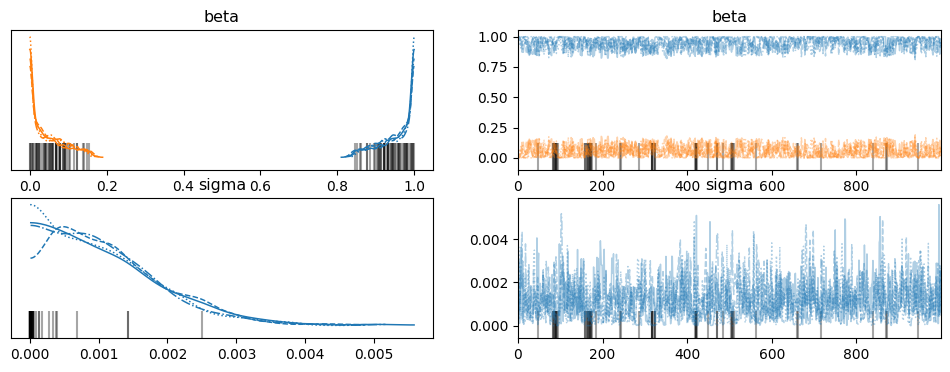

In [94]:
with preference_model:
    az.plot_trace(trace)

In [95]:
with preference_model:
    display(az.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.951,0.046,0.863,1.000,0.002,0.001,504.0,733.0,1.01
beta[1],0.049,0.046,0.000,0.137,0.002,0.001,504.0,733.0,1.01
sigma,0.001,0.001,0.000,0.003,0.000,0.000,661.0,493.0,1.01


In [96]:
idx = feedback_sc_df.pareto_fr.sample(1).index[0]
eff_front_df = pd.DataFrame(np.array(feedback_sc_df.pareto_fr.iloc[idx])[:, [1, 0]], columns=['mean', 'var'])
eff_front_df["weights"] = feedback_sc_df.pareto_fr_w.iloc[idx]

GT_eff_port = utils_fucns.get_eff_port(eff_front_df, GT_pref_model_scaler_path, GT_pref_model, trace["beta"], plot_eff_front=True)

## GT Model = 0.9 mean + 0.1 (-variance) (500 observations)

In [97]:
def GT_pref_model(criteria):
    return 0.9*criteria[0] - 0.1*criteria[1]

In [98]:
num_comparisons = 500
model_name = f"GT_model_4_{num_comparisons}"
GT_pref_model_data_path = f"./Data/GT_pref_models/{stock_index_name}/{model_name}_data.json"
GT_pref_model_scaler_path = f"./Params/GT_pref_models/{stock_index_name}/{model_name}/scaler.joblib"

In [99]:
feedback_df = utils_fucns.create_comparison_dataset(train_df, num_comparisons)
feedback_sc_df = utils_fucns.scale_feedback_df(feedback_df, GT_pref_model_scaler_path)
pref_portfolios = utils_fucns.get_preferred_portfolio(feedback_sc_df, GT_pref_model)
utils_fucns.rebalance_classes(feedback_sc_df, 2)
feedback_sc_df.reset_index().to_json(GT_pref_model_data_path)

In [100]:
feedback_sc_df = pd.read_json(GT_pref_model_data_path)
feedback_sc_df.drop('index', inplace=True, axis=1)
feedback_sc_df.head()

,mean1,var1,mean2,var2,port_returns1,port_returns2,pareto_fr,pareto_fr_w,pref_portfolio
0,0.128569,0.008446,0.173323,0.015624,"[-0.0108682393, 0.0019657867, -0.0012728884000...","[-0.0114866336, 0.0025955756, 0.0028568799, -0...","[[4.09126e-05, 0.0012000296], [3.64635e-05, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0919649277, ...",1
1,0.184320,0.007642,0.258248,0.032942,"[0.0089773877, 0.011962564600000001, 0.0242257...","[0.0280273256, 0.0181419689, 0.0438235426, 2.5...","[[5.4817e-05, 0.0018671787000000002], [4.85165...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
2,0.152577,0.007694,0.246626,0.042335,"[0.0195840407, 0.0067192178, 0.0053362791, 0.0...","[0.0193074185, 0.011895487000000001, 0.0063074...","[[0.00025294120000000003, 0.0029971765], [4.40...","[[0.0, 0.1771582566, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,0.507012,0.079854,0.583682,0.146852,"[-0.033703714600000004, 0.051052082000000006, ...","[-0.061334765000000006, 0.0710219274, 0.013679...","[[8.0302e-05, 0.0019608064], [0.00012434070000...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
4,0.180099,0.022656,0.308640,0.093758,"[0.0031060012000000002, 0.0052166582, -0.00202...","[-0.0007068392, 0.0083854725, -0.0076075570000...","[[0.00019704420000000002, 0.002511558], [0.001...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1


In [101]:
with pm.Model() as preference_model:
    beta = pm.Dirichlet("beta", a=np.ones(2)/2)
    sigma = pm.Exponential("sigma", 1)
    
    vm = beta[0]*feedback_sc_df.mean2.values + beta[1]*-feedback_sc_df.var2.values
    vr = beta[0]*feedback_sc_df.mean1.values + beta[1]*-feedback_sc_df.var1.values

    Norm_dist = pm.Normal.dist(0, 1)
    p = 1 - pm.math.exp(Norm_dist.logcdf(-(vm - vr)/pm.math.sqrt(2*sigma**2)))

    Y_obs = pm.Bernoulli("Y_obs", p=p, observed=feedback_sc_df.pref_portfolio.values)

In [102]:
with preference_model:
    trace = pm.sample(1000, tune = 10000, return_inferencedata=False, target_accept=0.999)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

Sampling 4 chains for 10_000 tune and 1_000 draw iterations (40_000 + 4_000 draws total) took 90 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There

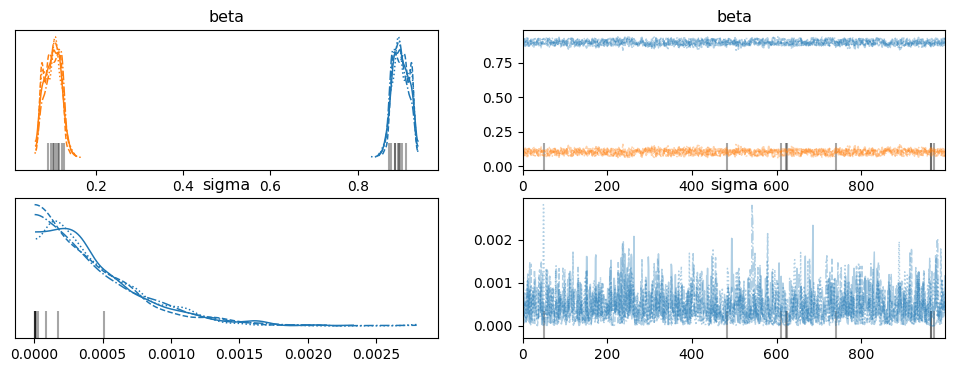

In [103]:
with preference_model:
    az.plot_trace(trace)

In [104]:
with preference_model:
    display(az.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.898,0.018,0.870,0.931,0.001,0.0,910.0,1426.0,1.0
beta[1],0.102,0.018,0.069,0.130,0.001,0.0,910.0,1426.0,1.0
sigma,0.000,0.000,0.000,0.001,0.000,0.0,984.0,905.0,1.0


In [105]:
idx = feedback_sc_df.pareto_fr.sample(1).index[0]
eff_front_df = pd.DataFrame(np.array(feedback_sc_df.pareto_fr.iloc[idx])[:, [1, 0]], columns=['mean', 'var'])
eff_front_df["weights"] = feedback_sc_df.pareto_fr_w.iloc[idx]

GT_eff_port = utils_fucns.get_eff_port(eff_front_df, GT_pref_model_scaler_path, GT_pref_model, trace["beta"], plot_eff_front=True)

## GT Model = 0.5 mean + 0.5 (-variance) (200 observations)

In [106]:
def GT_pref_model(criteria):
    return 0.5*criteria[0] - 0.5*criteria[1]

In [107]:
num_comparisons = 200
model_name = f"GT_model_5_{num_comparisons}"
GT_pref_model_data_path = f"./Data/GT_pref_models/{stock_index_name}/{model_name}_data.json"
GT_pref_model_scaler_path = f"./Params/GT_pref_models/{stock_index_name}/{model_name}/scaler.joblib"

In [108]:
feedback_df = utils_fucns.create_comparison_dataset(train_df, num_comparisons)
feedback_sc_df = utils_fucns.scale_feedback_df(feedback_df, GT_pref_model_scaler_path)
pref_portfolios = utils_fucns.get_preferred_portfolio(feedback_sc_df, GT_pref_model)
utils_fucns.rebalance_classes(feedback_sc_df, 2)
feedback_sc_df.reset_index().to_json(GT_pref_model_data_path)

In [109]:
feedback_sc_df = pd.read_json(GT_pref_model_data_path)
feedback_sc_df.drop('index', inplace=True, axis=1)
feedback_sc_df.head()

,mean1,var1,mean2,var2,port_returns1,port_returns2,pareto_fr,pareto_fr_w,pref_portfolio
0,0.369375,0.355064,0.361394,0.324370,"[-0.017135095, -0.0238357374, -0.0165763712000...","[-0.0152314556, -0.0222885912, -0.015658790500...","[[0.000161735, 0.0025753738], [0.0015141753, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
1,0.188757,0.019386,0.259199,0.082918,"[0.0101165352, 0.012958576500000001, 0.0269853...","[0.028429357000000002, 0.019084261300000002, 0...","[[6.73344e-05, 0.0022339182], [8.9103e-05, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
2,0.337872,0.256404,0.318857,0.205644,"[0.0108934144, -0.0037645748, -0.0033281170000...","[0.0103494268, -0.0022222045, -0.00754345, 0.0...","[[0.00036731970000000003, 0.0034090698], [0.00...","[[0.1741140908, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,0.135935,0.016183,0.252616,0.068404,"[0.0038734606, 0.0070974518000000006, -0.01196...","[0.0022413697000000002, 0.015646771400000002, ...","[[0.000326092, 0.0035376753], [4.01804e-05, 0....","[[0.0, 0.1814222324, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,0.321403,0.130339,0.339587,0.153191,"[-0.0121753667, 0.007610291700000001, 0.005593...","[-0.0159487546, 0.0068093307, 0.007510313, -0....","[[0.00012804370000000002, 0.0025705145], [0.00...","[[0.2468419232, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [110]:
with pm.Model() as preference_model:
    beta = pm.Dirichlet("beta", a=np.ones(2)/2)
    sigma = pm.Exponential("sigma", 1)
    
    vm = beta[0]*feedback_sc_df.mean2.values + beta[1]*-feedback_sc_df.var2.values
    vr = beta[0]*feedback_sc_df.mean1.values + beta[1]*-feedback_sc_df.var1.values

    Norm_dist = pm.Normal.dist(0, 1)
    p = 1 - pm.math.exp(Norm_dist.logcdf(-(vm - vr)/pm.math.sqrt(2*sigma**2)))

    Y_obs = pm.Bernoulli("Y_obs", p=p, observed=feedback_sc_df.pref_portfolio.values)

In [111]:
with preference_model:
    trace = pm.sample(1000, tune = 10000, return_inferencedata=False, target_accept=0.999)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

Sampling 4 chains for 10_000 tune and 1_000 draw iterations (40_000 + 4_000 draws total) took 127 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Th

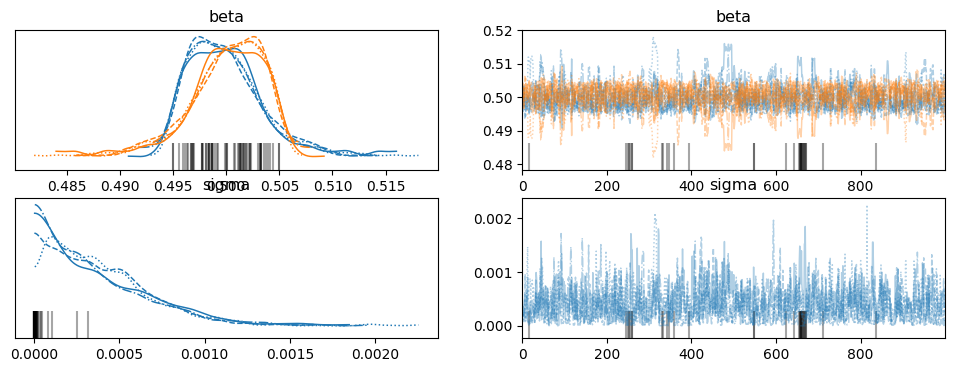

In [112]:
with preference_model:
    az.plot_trace(trace)

In [113]:
with preference_model:
    display(az.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.5,0.004,0.494,0.508,0.0,0.0,605.0,435.0,1.0
beta[1],0.5,0.004,0.492,0.506,0.0,0.0,605.0,435.0,1.0
sigma,0.0,0.000,0.000,0.001,0.0,0.0,491.0,399.0,1.0


In [114]:
idx = feedback_sc_df.pareto_fr.sample(1).index[0]
eff_front_df = pd.DataFrame(np.array(feedback_sc_df.pareto_fr.iloc[idx])[:, [1, 0]], columns=['mean', 'var'])
eff_front_df["weights"] = feedback_sc_df.pareto_fr_w.iloc[idx]

GT_eff_port = utils_fucns.get_eff_port(eff_front_df, GT_pref_model_scaler_path, GT_pref_model, trace["beta"], plot_eff_front=True)

# Slow Change of Preferences Regimes

In [115]:
def GT_pref_model_0(criteria):
    return 0.8*criteria[0] - 0.2*criteria[1]

class GT_pref_model_1(object):
    def __init__(self, regime, num_regimes):
        self.regime = regime
        self.num_regimes = num_regimes

    def __call__(self, criteria):
        return (0.8 + self.regime*(0.2 - 0.8)/(self.num_regimes - 1))*criteria[0] -\
               (0.2 + self.regime*(0.8 - 0.2)/(self.num_regimes - 1))*criteria[1]
    
def GT_pref_model_2(criteria):
    return 0.2*criteria[0] - 0.8*criteria[1]

In [116]:
num_comparisons = 50
regimes_name = f"slow_change_regimes"
regimes_dfs = utils_fucns.separate_df_regimes(train_df, "6M")
scaler_path = f"./Params/GT_pref_models_regimes/{regimes_name}/{stock_index_name}/scalers/"
data_path = f"./Data/GT_pref_models_regimes/{regimes_name}/{stock_index_name}/"

In [117]:
for i in range(len(regimes_dfs) - 1):
    data_file_name = f"GT_model_data_{i}.json"
    scaler_file_name = f"scaler_{i}.joblib"
    feedback_df = utils_fucns.create_comparison_dataset(regimes_dfs[i], num_comparisons=num_comparisons)
    feedback_sc_df = utils_fucns.scale_feedback_df(feedback_df, scaler_path + scaler_file_name)
    if i < 5:
        model = GT_pref_model_0
    elif i >= 5 and i < 16:
        model = GT_pref_model_1(regime=i - 5, num_regimes=11)
    else:
        model = GT_pref_model_2
    pref_portfolios = utils_fucns.get_preferred_portfolio(feedback_sc_df, model)
    utils_fucns.rebalance_classes(feedback_sc_df, 2)
    feedback_sc_df.reset_index().to_json(data_path + data_file_name)
    print(f"Successfully saved {data_file_name}")

Successfully saved GT_model_data_0.json
Successfully saved GT_model_data_1.json
Successfully saved GT_model_data_2.json
Successfully saved GT_model_data_3.json
Successfully saved GT_model_data_4.json
Successfully saved GT_model_data_5.json
Successfully saved GT_model_data_6.json
Successfully saved GT_model_data_7.json
Successfully saved GT_model_data_8.json
Successfully saved GT_model_data_9.json
Successfully saved GT_model_data_10.json
Successfully saved GT_model_data_11.json
Successfully saved GT_model_data_12.json
Successfully saved GT_model_data_13.json
Successfully saved GT_model_data_14.json
Successfully saved GT_model_data_15.json
Successfully saved GT_model_data_16.json
Successfully saved GT_model_data_17.json
Successfully saved GT_model_data_18.json
Successfully saved GT_model_data_19.json


In [118]:
window_size = 1

feedback_sc_dfs = []
for i in range(len(os.listdir(data_path))):
    feedback_sc_df = pd.read_json(data_path + "/" + f"GT_model_data_{i}.json")
    feedback_sc_df.drop('index', inplace=True, axis=1)
    feedback_sc_dfs.append(feedback_sc_df)

feedback_sc_dfs = feedback_sc_dfs[::-1]
feedback_sc_dfs = [pd.concat(feedback_sc_dfs[i:i+window_size]) for i in range(len(feedback_sc_dfs))][::-1]

regimes_betas_df = utils_fucns.Fit_pref_model_regimes(feedback_sc_dfs)
regimes_betas_df.to_json(f"./Params/GT_pref_models_regimes/{regimes_name}/{stock_index_name}/betas_{window_size}.json")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

Sampling 4 chains for 10_000 tune and 1_000 draw iterations (40_000 + 4_000 draws total) took 173 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Th

In [119]:
window_size = 3

feedback_sc_dfs = []
for i in range(len(os.listdir(data_path))):
    feedback_sc_df = pd.read_json(data_path + "/" + f"GT_model_data_{i}.json")
    feedback_sc_df.drop('index', inplace=True, axis=1)
    feedback_sc_dfs.append(feedback_sc_df)

feedback_sc_dfs = feedback_sc_dfs[::-1]
feedback_sc_dfs = [pd.concat(feedback_sc_dfs[i:i+window_size]) for i in range(len(feedback_sc_dfs))][::-1]

regimes_betas_df = utils_fucns.Fit_pref_model_regimes(feedback_sc_dfs)
regimes_betas_df.to_json(f"./Params/GT_pref_models_regimes/{regimes_name}/{stock_index_name}/betas_{window_size}.json")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

Sampling 4 chains for 10_000 tune and 1_000 draw iterations (40_000 + 4_000 draws total) took 71 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There

In [120]:
def true_betas(regime, beta):
    if regime < 5:
        if beta == "Beta_1":
            return 0.8
        if beta == "Beta_2":
            return 0.2
    elif regime >= 5 and regime < 16:
        if beta == "Beta_1":
            return 0.8 + (regime - 5)*(0.2 - 0.8)/(10)
        if beta == "Beta_2":
            return 0.2 + (regime - 5)*(0.8 - 0.2)/(10)
    else:
        if beta == "Beta_1":
            return 0.2
        if beta == "Beta_2":
            return 0.8

regimes_betas_dfs = [
    pd.read_json(f"./Params/GT_pref_models_regimes/{regimes_name}/{stock_index_name}/betas_3.json"),
    pd.read_json(f"./Params/GT_pref_models_regimes/{regimes_name}/{stock_index_name}/betas_1.json")
]

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

for i in range(len(regimes_betas_dfs)):
    df = pd.DataFrame()
    for col in regimes_betas_dfs[i].columns:
        regime_num = int(col.split("_")[1])
        temp_df = pd.DataFrame()
        temp_df[["Beta_1", "Beta_2"]] = regimes_betas_dfs[i][col].tolist()
        temp_df["Regime"] = regime_num
        df = pd.concat([df, temp_df], axis=0)

    df = df.melt(id_vars=["Regime"], var_name="Beta", value_name="Value")

    df2 = df.groupby(["Regime", "Beta"]).mean().reset_index()
    df2.rename(columns={"Value": "Mean"}, inplace=True)
    quantiles_df = df.groupby(["Regime", "Beta"]).quantile([0.05, 0.95])
    df2["q_05"] = quantiles_df.xs((0.05), level=2).values
    df2["q_95"] = quantiles_df.xs((0.95), level=2).values
    df2["True"] = df2.apply(lambda x: true_betas(x.Regime, x.Beta), axis=1)
    showlegend = True if i == 0 else False

    fig.add_trace(go.Scatter(x=df2[df2["Beta"] == "Beta_1"]["Regime"],
                             y=df2[df2["Beta"] == "Beta_1"]["Mean"],
                             line=dict(dash="dot", color="blue", width=3),
                             legendgroup=0,
                             showlegend=showlegend,
                             legendgrouptitle_text="Estimated",
                             name="Beta 1"), col=1, row=i + 1)
    fig.add_trace(go.Scatter(x=df2[df2["Beta"] == "Beta_1"]["Regime"],
                             y=df2[df2["Beta"] == "Beta_1"]["True"],
                             line=dict(color="blue", width=1),
                             legendgroup=1,
                             showlegend=showlegend,
                             legendgrouptitle_text="True",
                             name="Beta 1"), col=1, row=i + 1)
    fig.add_trace(go.Scatter(x=df2[df2["Beta"] == "Beta_2"]["Regime"],
                             y=df2[df2["Beta"] == "Beta_2"]["Mean"],
                             line=dict(dash="dot", color="red", width=3),
                             legendgroup=0,
                             showlegend=showlegend,
                             name="Beta 2"), col=1, row=i + 1)
    fig.add_trace(go.Scatter(x=df2[df2["Beta"] == "Beta_2"]["Regime"],
                             y=df2[df2["Beta"] == "Beta_2"]["True"],
                             line=dict(color="red", width=1),
                             legendgroup=1,
                             showlegend=showlegend,
                             name="Beta 2"), col=1, row=i + 1)

    fig.add_trace(go.Scatter(x=pd.concat([df2[df2["Beta"] == "Beta_1"]["Regime"], df2[df2["Beta"] == "Beta_1"]["Regime"][::-1]]), 
                               y=pd.concat([df2[df2["Beta"] == "Beta_1"]["q_95"], df2[df2["Beta"] == "Beta_1"]["q_05"][::-1]]),
                               mode = 'lines', line_color = 'rgba(0,0,0,0)',
                               name = '90% CI',
                               showlegend=showlegend,
                               fill='toself', fillcolor = 'rgba(31, 119, 180, 0.3)'), col=1, row=i + 1)
    fig.add_trace(go.Scatter(x=pd.concat([df2[df2["Beta"] == "Beta_2"]["Regime"], df2[df2["Beta"] == "Beta_2"]["Regime"][::-1]]), 
                               y=pd.concat([df2[df2["Beta"] == "Beta_2"]["q_95"], df2[df2["Beta"] == "Beta_2"]["q_05"][::-1]]),
                               mode = 'lines', line_color = 'rgba(0,0,0,0)',
                               name = '90% CI',
                               showlegend=showlegend,
                               fill='toself', fillcolor = 'rgba(255, 0, 0, 0.3)'), col=1, row=i + 1)

    if i == 1:
        fig.update_xaxes(title="Semester", col=1, row=2)

    fig.update_layout(legend=dict(font=dict(size= 10)), legend_title=dict(font=dict(size=10)))

#fig.update_layout(margin=dict(l=20, r=20, t=20, b=20), template="simple_white")
fig.update_layout(margin=dict(l=20, r=20, t=20, b=20), template="simple_white", font=dict(family="Times New Roman", size=22.5),
                  legend=dict(font=dict(family="Times New Roman", size=17.5)))
#fig.write_image("./Images/Case1_BetaEstimation.pdf")
fig.show()

# Rapid Change of Preferences Regimes

In [121]:
def GT_pref_model_0(criteria):
    return 0.6*criteria[0] - 0.4*criteria[1]

def GT_pref_model_1(criteria):
    return 0.3*criteria[0] - 0.7*criteria[1]

def GT_pref_model_2(criteria):
    return 0.8*criteria[0] - 0.2*criteria[1]

In [122]:
num_comparisons = 50
regimes_name = f"rapid_change_regimes"
regimes_dfs = utils_fucns.separate_df_regimes(train_df, "6M")
scaler_path = f"./Params/GT_pref_models_regimes/{regimes_name}/{stock_index_name}/scalers/"
data_path = f"./Data/GT_pref_models_regimes/{regimes_name}/{stock_index_name}/"

In [123]:
for i in range(len(regimes_dfs) - 1):
    data_file_name = f"GT_model_data_{i}.json"
    scaler_file_name = f"scaler_{i}.joblib"
    feedback_df = utils_fucns.create_comparison_dataset(regimes_dfs[i], num_comparisons=num_comparisons)
    feedback_sc_df = utils_fucns.scale_feedback_df(feedback_df, scaler_path + scaler_file_name)
    if i < 5:
        model = GT_pref_model_0
    elif i >= 5 and i < 12:
        model = GT_pref_model_1
    else:
        model = GT_pref_model_2
    pref_portfolios = utils_fucns.get_preferred_portfolio(feedback_sc_df, model)
    utils_fucns.rebalance_classes(feedback_sc_df, 2)
    feedback_sc_df.reset_index().to_json(data_path + data_file_name)
    print(f"Successfully saved {data_file_name}")

Successfully saved GT_model_data_0.json
Successfully saved GT_model_data_1.json
Successfully saved GT_model_data_2.json
Successfully saved GT_model_data_3.json
Successfully saved GT_model_data_4.json
Successfully saved GT_model_data_5.json
Successfully saved GT_model_data_6.json
Successfully saved GT_model_data_7.json
Successfully saved GT_model_data_8.json
Successfully saved GT_model_data_9.json
Successfully saved GT_model_data_10.json
Successfully saved GT_model_data_11.json
Successfully saved GT_model_data_12.json
Successfully saved GT_model_data_13.json
Successfully saved GT_model_data_14.json
Successfully saved GT_model_data_15.json
Successfully saved GT_model_data_16.json
Successfully saved GT_model_data_17.json
Successfully saved GT_model_data_18.json


/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/GithubRepo/utils/utils.py:35: RuntimeWarning:

invalid value encountered in true_divide



Successfully saved GT_model_data_19.json


In [124]:
window_size = 1

feedback_sc_dfs = []
for i in range(len(os.listdir(data_path))):
    feedback_sc_df = pd.read_json(data_path + "/" + f"GT_model_data_{i}.json")
    feedback_sc_df.drop('index', inplace=True, axis=1)
    feedback_sc_dfs.append(feedback_sc_df)

feedback_sc_dfs = feedback_sc_dfs[::-1]
feedback_sc_dfs = [pd.concat(feedback_sc_dfs[i:i+window_size]) for i in range(len(feedback_sc_dfs))][::-1]

regimes_betas_df = utils_fucns.Fit_pref_model_regimes(feedback_sc_dfs)
regimes_betas_df.to_json(f"./Params/GT_pref_models_regimes/{regimes_name}/{stock_index_name}/betas_{window_size}.json")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

Sampling 4 chains for 10_000 tune and 1_000 draw iterations (40_000 + 4_000 draws total) took 68 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The

In [125]:
window_size = 3

feedback_sc_dfs = []
for i in range(len(os.listdir(data_path))):
    feedback_sc_df = pd.read_json(data_path + "/" + f"GT_model_data_{i}.json")
    feedback_sc_df.drop('index', inplace=True, axis=1)
    feedback_sc_dfs.append(feedback_sc_df)

feedback_sc_dfs = feedback_sc_dfs[::-1]
feedback_sc_dfs = [pd.concat(feedback_sc_dfs[i:i+window_size]) for i in range(len(feedback_sc_dfs))][::-1]

regimes_betas_df = utils_fucns.Fit_pref_model_regimes(feedback_sc_dfs)
regimes_betas_df.to_json(f"./Params/GT_pref_models_regimes/{regimes_name}/{stock_index_name}/betas_{window_size}.json")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

/mnt/c/Users/josea/OneDrive/Escritorio/Trabajos/Proyectos/Human Preferences RL/.venv/lib/python3.8/site-packages/theano/compile/function/types.py:974: RuntimeWarning:

invalid value encountered in add

Sampling 4 chains for 10_000 tune and 1_000 draw iterations (40_000 + 4_000 draws total) took 74 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The

In [126]:
def true_betas(regime, beta):
    if regime < 5:
        if beta == "Beta_1":
            return 0.6
        if beta == "Beta_2":
            return 0.4
    elif regime >= 5 and regime < 12:
        if beta == "Beta_1":
            return 0.3
        if beta == "Beta_2":
            return 0.7
    else:
        if beta == "Beta_1":
            return 0.8
        if beta == "Beta_2":
            return 0.2

regimes_betas_dfs = [
    pd.read_json(f"./Params/GT_pref_models_regimes/{regimes_name}/{stock_index_name}/betas_3.json"),
    pd.read_json(f"./Params/GT_pref_models_regimes/{regimes_name}/{stock_index_name}/betas_1.json")
]

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

for i in range(len(regimes_betas_dfs)):
    df = pd.DataFrame()
    for col in regimes_betas_dfs[i].columns:
        regime_num = int(col.split("_")[1])
        temp_df = pd.DataFrame()
        temp_df[["Beta_1", "Beta_2"]] = regimes_betas_dfs[i][col].tolist()
        temp_df["Regime"] = regime_num
        df = pd.concat([df, temp_df], axis=0)

    df = df.melt(id_vars=["Regime"], var_name="Beta", value_name="Value")

    df2 = df.groupby(["Regime", "Beta"]).mean().reset_index()
    df2.rename(columns={"Value": "Mean"}, inplace=True)
    quantiles_df = df.groupby(["Regime", "Beta"]).quantile([0.05, 0.95])
    df2["q_05"] = quantiles_df.xs((0.05), level=2).values
    df2["q_95"] = quantiles_df.xs((0.95), level=2).values
    df2["True"] = df2.apply(lambda x: true_betas(x.Regime, x.Beta), axis=1)
    showlegend = True if i == 0 else False

    fig.add_trace(go.Scatter(x=df2[df2["Beta"] == "Beta_1"]["Regime"],
                             y=df2[df2["Beta"] == "Beta_1"]["Mean"],
                             line=dict(dash="dot", color="blue", width=3),
                             legendgroup=0,
                             showlegend=showlegend,
                             legendgrouptitle_text="Estimated",
                             name="Beta 1"), col=1, row=i + 1)
    fig.add_trace(go.Scatter(x=df2[df2["Beta"] == "Beta_1"]["Regime"],
                             y=df2[df2["Beta"] == "Beta_1"]["True"],
                             line=dict(color="blue", width=1),
                             legendgroup=1,
                             showlegend=showlegend,
                             legendgrouptitle_text="True",
                             name="Beta 1"), col=1, row=i + 1)
    fig.add_trace(go.Scatter(x=df2[df2["Beta"] == "Beta_2"]["Regime"],
                             y=df2[df2["Beta"] == "Beta_2"]["Mean"],
                             line=dict(dash="dot", color="red", width=3),
                             legendgroup=0,
                             showlegend=showlegend,
                             name="Beta 2"), col=1, row=i + 1)
    fig.add_trace(go.Scatter(x=df2[df2["Beta"] == "Beta_2"]["Regime"],
                             y=df2[df2["Beta"] == "Beta_2"]["True"],
                             line=dict(color="red", width=1),
                             legendgroup=1,
                             showlegend=showlegend,
                             name="Beta 2"), col=1, row=i + 1)

    fig.add_trace(go.Scatter(x=pd.concat([df2[df2["Beta"] == "Beta_1"]["Regime"], df2[df2["Beta"] == "Beta_1"]["Regime"][::-1]]), 
                               y=pd.concat([df2[df2["Beta"] == "Beta_1"]["q_95"], df2[df2["Beta"] == "Beta_1"]["q_05"][::-1]]),
                               mode = 'lines', line_color = 'rgba(0,0,0,0)',
                               name = '90% CI',
                               showlegend=showlegend,
                               fill='toself', fillcolor = 'rgba(31, 119, 180, 0.3)'), col=1, row=i + 1)
    fig.add_trace(go.Scatter(x=pd.concat([df2[df2["Beta"] == "Beta_2"]["Regime"], df2[df2["Beta"] == "Beta_2"]["Regime"][::-1]]), 
                               y=pd.concat([df2[df2["Beta"] == "Beta_2"]["q_95"], df2[df2["Beta"] == "Beta_2"]["q_05"][::-1]]),
                               mode = 'lines', line_color = 'rgba(0,0,0,0)',
                               name = '90% CI',
                               showlegend=showlegend,
                               fill='toself', fillcolor = 'rgba(255, 0, 0, 0.3)'), col=1, row=i + 1)

    if i == 1:
        fig.update_xaxes(title="Semester", col=1, row=2)

    fig.update_layout(legend=dict(font=dict(size= 10)), legend_title=dict(font=dict(size=10)))

#fig.update_layout(margin=dict(l=20, r=20, t=20, b=20), template="simple_white")
fig.update_layout(margin=dict(l=20, r=20, t=20, b=20), template="simple_white", font=dict(family="Times New Roman", size=22.5),
                  legend=dict(font=dict(family="Times New Roman", size=17.5)))
#fig.write_image("./Images/Case1_BetaEstimation.pdf")
fig.show()